# Профильное задание

Вначале подгрузим данные (я сохранил их на Гугл.Диск).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive

/content/drive/MyDrive


In [4]:
import zipfile

zip = zipfile.ZipFile('drive-download-20240306T181341Z-001.zip')
zip.extractall('/content/')

In [5]:
%cd /content

/content


In [6]:
import pandas as pd

train = pd.read_csv('train_df.csv')
test = pd.read_csv('test_df.csv')
train.head()

,search_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,target
0,758,9,0,0,1,20,3,40,0,3,...,0.204682,0.271755,0.055623,0,0,0,0.38648,0.0,0.0,0
1,758,9,0,0,1,20,3,40,0,3,...,0.195531,0.188787,0.036914,0,0,0,0.10982,0.0,0.0,0
2,758,9,0,0,1,20,3,40,0,3,...,0.148609,0.186517,0.027718,0,0,0,0.03674,0.0,0.0,0
3,758,9,0,0,1,20,3,40,0,3,...,0.223748,0.229039,0.051247,0,0,0,0.00000,0.0,0.0,0
4,758,9,0,0,1,20,3,40,0,3,...,0.170935,0.249031,0.042568,0,0,0,0.00000,0.0,0.0,0


В наборе данных не содержится какой-то информации о взаимной релевантности запросов, зато указана целевая переменная, которая может быть равна либо 0, либо 1. Таким образом, кажется разумным свести задачу ранжирования к бинарной классификации, что я и попытался сделать

Удалим из тренировочного датасета повторяющиеся строки.

In [7]:
train = train.drop_duplicates().reset_index(drop=True)

Посмотрим, есть ли в наборах данных NaN-значения.

In [8]:
nan_train = pd.DataFrame(train[:].isna().sum()).transpose()
nan_train

,search_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
nan_test = pd.DataFrame(test[:].isna().sum()).transpose()
nan_test

,search_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


NaN-значений нет, это радует.

Посмотрим, какие типы данных представлены в выборке и надо ли их редактировать.

In [10]:
import numpy as np

In [11]:
print('TRAIN')
print(train.dtypes)
print(np.sum(train.dtypes==object))
print('\nTEST')
print(test.dtypes)
print(np.sum(test.dtypes==object))

TRAIN
search_id       int64
feature_0       int64
feature_1       int64
feature_2       int64
feature_3       int64
               ...   
feature_75      int64
feature_76    float64
feature_77    float64
feature_78    float64
target          int64
Length: 81, dtype: object
0

TEST
search_id       int64
feature_0       int64
feature_1       int64
feature_2       int64
feature_3       int64
               ...   
feature_75      int64
feature_76    float64
feature_77    float64
feature_78    float64
target          int64
Length: 81, dtype: object
0


В наборе данных нет категориальных признаков, а все числовые признаки имеют верный тип.

Посмтрим на распределение целевой переменной.

Text(0.5, 1.0, 'target - TEST')

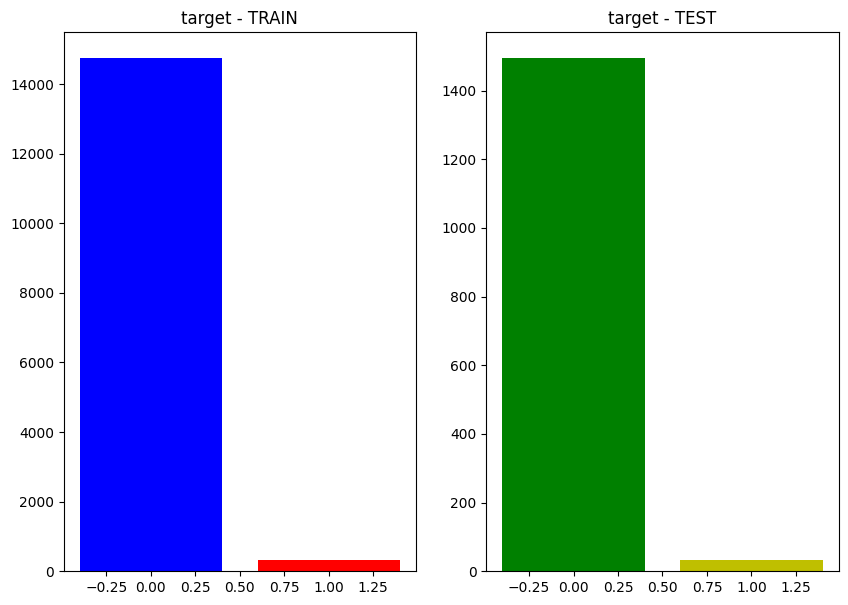

In [12]:
import matplotlib.pyplot as plt

col = 'target'
fig, axs = plt.subplots(1, 2, figsize=(10,7))
count_train = train[col].value_counts()
count_test = test[col].value_counts()
axs[0].bar(count_train.keys(), count_train, color=['b','r'])
axs[0].set_title(col+' - TRAIN')
axs[1].bar(count_test.keys(), count_test, color=['g','y'])
axs[1].set_title(col+' - TEST')

Видна сильная несбалансированность классов. Это надо учитывать при дальнейшей обработке данных.

Удалим все малоинформативные константные признаки.

In [13]:
train = train.loc[:, train[list(train)].std()!=0]
test = test.loc[:, test[list(test)].std()!=0]

Получим корреляционную матрицу для признаков, а затем почистим признаки с высокой корреляцией, оставив для каждой пары таких признаков какой-то один.

In [14]:
import numpy as np

def rm_corrs(df, threshold=0.95):
    corr_m = df.corr().abs()
    upper = corr_m.where(np.triu(np.ones(corr_m.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(to_drop, axis = 1)

train_target = train['target'].copy(deep=True)
test_target = test['target'].copy(deep=True)
train = rm_corrs(train.loc[:,:'feature_78'])
train['target'] = train_target
test = rm_corrs(test.loc[:,:'feature_78'])
test['target'] = test_target

Обработанный набор обучающих данных имеет вид:

In [15]:
train

,search_id,feature_1,feature_2,feature_3,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_76,feature_77,target
0,758,0,0,1,3,40,0,3,1,0,...,0.054861,0.433005,0.188131,0.0734,0.204682,0.271755,0.055623,0.38648,0.0,0
1,758,0,0,1,3,40,0,3,0,0,...,0.853441,0.290734,0.048554,0.0382,0.195531,0.188787,0.036914,0.10982,0.0,0
2,758,0,0,1,3,40,0,3,1,0,...,0.857800,0.287074,0.045502,0.1510,0.148609,0.186517,0.027718,0.03674,0.0,0
3,758,0,0,1,3,40,0,3,1,1,...,0.000000,0.469645,0.145031,0.0699,0.223748,0.229039,0.051247,0.00000,0.0,0
4,758,0,0,1,3,40,0,3,1,1,...,0.000000,0.200816,0.061071,0.0382,0.170935,0.249031,0.042568,0.00000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15064,494693,0,0,0,4,38,6,6,1,1,...,0.246707,0.683106,0.852841,0.0661,0.309672,0.921060,0.285226,0.98807,0.0,0
15065,494693,0,0,0,4,38,6,6,1,0,...,0.800668,0.755745,0.658246,0.1899,0.303805,0.995086,0.302312,0.87146,0.0,0
15066,494693,0,0,0,4,38,6,6,0,1,...,0.001164,0.583024,0.763281,0.0664,0.346538,0.993070,0.344137,0.49999,0.0,0
15067,494693,0,0,0,4,38,6,6,1,1,...,0.821496,0.664485,0.893621,0.1899,0.243154,0.994833,0.241898,0.67614,0.0,0


Убедимся, что из тренировочной и тестовой выборок удалены одинаковые признаки.

In [16]:
list(train) == list(test)

True

Выполним декомпозицию признаков и посмотрим на их распределение.

In [17]:
from sklearn.manifold import TSNE

def train_test_plot(X_train_, y_train, X_test_, y_test, title1="Train", title2="Test"):
    plt.figure(figsize=(16, 7))
    X_train = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X_train_)
    X_test = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(X_test_)
    ax = plt.subplot(121)
    plt.title(title1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    _ = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="Set3", ec='black', alpha=0.85, lw=0.5)

    plt.subplot(122, sharex=ax, sharey=ax)
    plt.title(title2)
    plt.xlabel("$x_1$")
    _ = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="Set3", ec='black', alpha=0.85, lw=0.5)

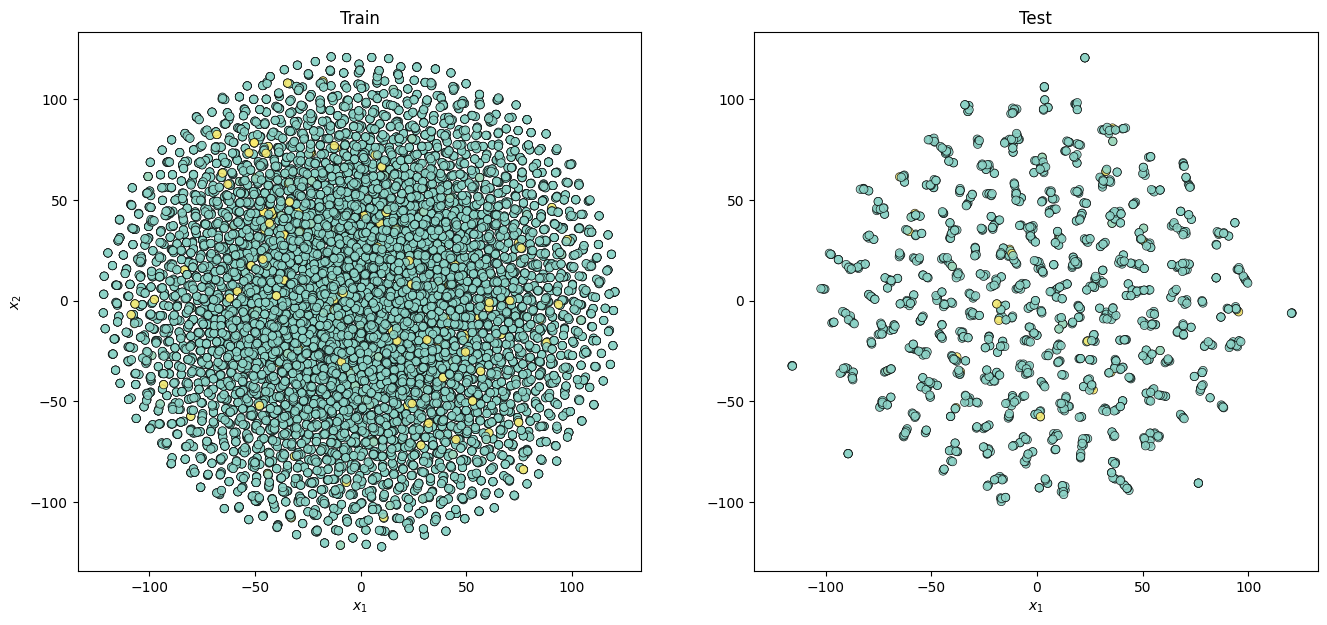

In [18]:
train_test_plot(train.loc[:,:'feature_77'], train['target'], test.loc[:,:'feature_77'], test['target'])

При обучении я использовал библтиотеку catboost. Пытался завернуть что-нибудь с pytorch и нейронными сетями, но в итоге для градиентного бустинга получился наилучший результат (хотя и не слишком большой).

In [19]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.5 MB/s eta 0:00:00


Будем перебирать различные параметры классификатора с целью выбрать наиболее оптимальные.

В качестве метрики я использовал F1-меру.

In [20]:
import random

random.seed(0xDEAD)
np.random.seed(0xDEAD)

In [21]:
import catboost

params = {'n_estimators': [50, 100, 200, 300], 'depth': [4, 6, 10], 'learning_rate': [0.05, 0.1, 0.5]}
boost = catboost.CatBoostClassifier(eval_metric='F1', auto_class_weights='Balanced')
catboost_result = boost.grid_search(params, train.loc[:,:'feature_77'], train['target'])
boost.save_model('last')
catboost_result

Выходные данные были обрезаны до нескольких последних строк (5000).
251:	learn: 0.9278992	test: 0.5809706	best: 0.5971743 (66)	total: 4.24s	remaining: 807ms
252:	learn: 0.9283180	test: 0.5674595	best: 0.5971743 (66)	total: 4.26s	remaining: 792ms
253:	learn: 0.9283180	test: 0.5537832	best: 0.5971743 (66)	total: 4.28s	remaining: 776ms
254:	learn: 0.9288134	test: 0.5540225	best: 0.5971743 (66)	total: 4.3s	remaining: 760ms
255:	learn: 0.9288897	test: 0.5539028	best: 0.5971743 (66)	total: 4.33s	remaining: 744ms
256:	learn: 0.9294621	test: 0.5542619	best: 0.5971743 (66)	total: 4.34s	remaining: 727ms
257:	learn: 0.9316636	test: 0.5396919	best: 0.5971743 (66)	total: 4.37s	remaining: 711ms
258:	learn: 0.9318164	test: 0.5402814	best: 0.5971743 (66)	total: 4.38s	remaining: 694ms
259:	learn: 0.9323901	test: 0.5406357	best: 0.5971743 (66)	total: 4.42s	remaining: 680ms
260:	learn: 0.9326198	test: 0.5407539	best: 0.5971743 (66)	total: 4.44s	remaining: 664ms
261:	learn: 0.9325050	test: 0.5409905	best:

{'params': {'depth': 4, 'learning_rate': 0.1, 'iterations': 100},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

Теперь посчитаем NDCG на тестовых данных. Я группировал тестовую выборку по search_id и считал NDCG внутри каждой подгруппы; при этом ввел несколько условий:
- если по какому-то search_id нет релевантных запросов и все таргет-переменные равны 0, я не учитывал такой запрос в общем результате (потому что нет смысла считать метрику для нерелевантных данных).
- если запрос с каким-то search_id был в выборке всего один, брал в качестве NCDG 1, если таргет и предсказание были равны, и 0, если не равны.

Итоговая NDCG - средняя для всех подгрупп.

In [23]:
from sklearn.metrics import ndcg_score


best_boost = catboost.CatBoostClassifier()
best_boost.load_model('last')

ndcg = 0
count = 0
for query in test['search_id'].unique():
    subdf = test[test['search_id'] == query].sort_values(by=['target'], ascending=False)
    preds = best_boost.predict_proba(subdf.loc[:, :'feature_77'])[:, 1]
    preds = (preds >= 0.5)
    if subdf.head(1)['target'].values:
        if subdf.shape[0] > 1:
            ndcg += ndcg_score([preds], [subdf['target']])
        else:
            ndcg += 1 * preds
        count += 1

ndcg[0]/count

0.4571593114919415

Результат вышел не совсем воодушевляющий, но, к сожалению, это лучшее, что я смог получить.